In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from math import *
from tqdm import tqdm

sources_folder = "data/"

data_sources = [
    ("R1B7_RvsT_5mV.xlsx","R1B7_0T_5mV"),
    ("R1B7_RvsT_5mV.xlsx","R1B7_0T_Coated"),
    ("R1B9_RvsT_5mV.xlsx","R_vs_T_R1B92_0T_5mV"),
    ("R1B9_RvsT_coated_0T_5mV.xlsx","R_vs_T_R1B92_0T_5mV"),
    ("R2B6_RvsT_5mV.xlsx","R2B6_0T_5mV"),
    ("R2B8_RvsT_coated_5mV.xlsx","R2B8_5mV_0T"),
    ("R2B9_RvsT_5mV.xlsx","R2B9_5mV_0T"),
]

data_map = {}

for file,sheet_name in tqdm(data_sources):
    df = pd.read_excel(sources_folder+file, sheet_name=sheet_name)
    # filter out negative currents for fitting purposes
    df = df[df.Current != "--"]
    df = df[df.Current > 0]

    df = df[df.Voltage != "--"]
    df = df[df.Temp != "--"]
    df["Conductance"] = df["Current"]/df["Voltage"]

    data_map[file+":"+sheet_name] = df


 14%|█▍        | 1/7 [00:22<02:12, 22.05s/it]

In [63]:
# conductance offsets manually recorded earlier based on original data

offsets = {
    "R1B7":8.7248E-08,
    "R1B9":1.4949E-07,
    "R2B8":1.5509E-07
}

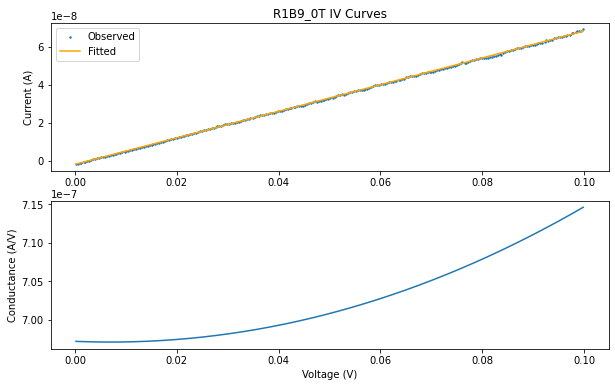

[1.4195684576601525e-07, 6.56239748472384e-07, -1.3755253728476655e-08, 6.971693860287876e-07, -1.9278252441107942e-09]


ValueError: `ydata` must not be empty!

In [76]:
sheet_name = ("R1B9_RvsT_coated_0T_5mV.xlsx"+":"+"R_vs_T_R1B92_0T_5mV")
short_name = sheet_name[:4]
df = data_map[sheet_name].copy()
df["Conductance"] -= offsets[short_name]
df=df.query("Conductance > 0")

temp, current, voltage, conductance = df["Temp"], df["Current"], df["Voltage"], df["Conductance"]
# apply offsets before anything happens

def plot_IV_curve_simple(file, sheet_name, axs=None, silent=False, voltage_upper_bound=None):
    """
    :param file: Name of the file to read from
    :param sheet_name: Name of the sheet in the file
    :param axs: Optional argument with axs to plot on
    """
    df = pd.read_excel(file, sheet_name=sheet_name)
    df = df.query("Voltage > 0")
    if voltage_upper_bound != None:
        df = df.query("Voltage < {}".format(voltage_upper_bound))
    if silent:
        return df['Voltage'], df['Current']

    if axs == None:
        axs = plt.axes()

    axs.plot(df['Voltage'], df['Current'])
    axs.set_xlabel("Voltage")
    axs.set_ylabel("Current")
    axs.set_title("Voltage-Current curve for {}".format(sheet_name))
    return df['Vsd'], df['Current']

sheet_name = "R1B9_0T"
voltages, currents = plot_IV_curve_simple(sources_folder+"IVs_at_100K-0Tvs7T.xlsx"
                                          , sheet_name=sheet_name, silent = True, voltage_upper_bound=0.1)

# force positive fitting coeffs so deriv is positive always
def fit_fun(x, a, b, c, d, f):
    return a * x ** 4 \
           + b * x ** 3 + c * x ** 2 + d * x + f

p, _ = curve_fit(fit_fun, voltages, currents,
                 bounds = [(0,-np.inf,-np.inf,-np.inf,-np.inf),(np.inf,np.inf,np.inf,np.inf,np.inf)],
                 p0 = [5e-16, 1.97e-08, 1.79e-07, 6.57e-07, 4.99e-21])
p = list(p)
outputs = np.polyval(p, voltages)
derivs = np.polyder(p)
deriv_outputs = np.polyval(derivs, voltages)



fig, axs = plt.subplots(2, figsize=(10, 6))
axs[0].set_title("{} IV Curves".format(sheet_name))
axs[1].set_xlabel("Voltage (V)")
axs[0].scatter(voltages, currents, s=2,label="Observed")
axs[0].plot(voltages, outputs, color='orange', label="Fitted")
plt.grid()
axs[0].legend()
axs[0].set_ylabel("Current (A)")

axs[1].plot(voltages, deriv_outputs)
axs[1].set_ylabel("Conductance (A/V)")
plt.savefig("graphs/IV Curves and Conductance {}".format(sheet_name).replace(".xlsx","").replace(":",""))
plt.grid()
plt.show()
print(p)


### Temp Conductance ###
def conductance_to_temp_fit(x, a, b, c, d):
    return np.tanh(a*x) * b * np.power(x,c) * np.exp(d*x)

coeffs, cov = curve_fit(conductance_to_temp_fit, np.array(conductance),
                        np.array(temp)
                        , bounds=((0,0,0,0),(np.inf,np.inf,1,np.inf))
                        , p0=[3.3e+08, 1.3e+03, 2.4e-01, 1e+06]
)


err = np.sqrt(np.diag(cov))
a,b,c,d = coeffs
# default args used to store values and make a closure
cond_to_temp  = lambda x, a=a, b=b, c=c, d=d: conductance_to_temp_fit(x,a,b,c,d)

plt.figure()
plt.grid()
plt.scatter(conductance,temp, s=.05,label="{} data".format(short_name))
plt.xlabel("Conductance (A/V)")
plt.ylabel("Temperature (K)")

# calibration_conductance is the expected conductance for 5mV at 100K
# since the two should fit at low voltage (Ohm heating regime)
calibration_conductance = np.polyval(derivs,5/1000)
plt.scatter([calibration_conductance], [100],s=10, color='green')

# do a binary search, assume f is monotonically increasing
def get_conductance_offset(target_t, f, threshold=0.01):
    mini = -1
    maxi = 1
    while f(maxi) < target_t:
        maxi*=2
    while f(mini) > target_t:
        mini*=2
    center = (mini+maxi)/2
    while abs(target_t-f(center)) > threshold:
        if f(center) < target_t:
            mini = center
        else:
            maxi = center
        center = (mini+maxi)/2
    return center

estimated_conductance = get_conductance_offset(100, cond_to_temp)
print("Conductance offset: ", estimated_conductance-calibration_conductance)
print("Current offset: ", (estimated_conductance-calibration_conductance)*5/1000)

domain = np.linspace(min(conductance), max(max(conductance),calibration_conductance), 1000)
fitted_temps = [cond_to_temp(c) for c in domain]
plt.plot(domain, fitted_temps,color='orange', label="{} prediction".format(short_name))
plt.title("Temperature vs Conductance")
plt.legend()


plt.savefig("graphs/Temperature vs Conductance {}".format(sheet_name).replace(".xlsx","").replace(":",""))
plt.show()
print(" "*44+"np.tanh(a*x) * b * np.power(x,c) * np.exp(d*x)")
print("Coefficients for {:<20}".format(short_name), coeffs)

plt.figure()



### now try to compute temperature from a given voltage
# plot voltages from 0 to 1
domain = np.linspace(0,.1,50000)
conductances = np.polyval(derivs, domain)
temps = cond_to_temp(conductances)
plt.plot(domain, temps)
plt.xlabel("Voltage (V)")
plt.ylabel("Predicted Temperature (K)")
plt.title("Temperature from voltage")
plt.savefig("graphs/Predicted temperature from voltage {}".format(short_name))
plt.grid()
plt.show()

print("Prediction for 5mV: {}".format(cond_to_temp(np.polyval(derivs,5/1000))))
print("Prediction for 0.2V: {}".format(cond_to_temp(np.polyval(derivs,0.2))))